# What jobs?

In [1]:
from Scratch import metadata_loader


DEVICE = "ibm_torino"
LOGICAL = str(0)
XBASIS = False
ROUNDS = 50

state = "X" if XBASIS else "Z"
state += LOGICAL
print(f"state = {state}")

# Load the metadata
md = metadata_loader(True, True)
md = md[md["job_status"] == "JobStatus.DONE"]
md = md[md["code"] == "RepetitionCodeCircuit"]
md = md[md["descr"] == 'subset RepCodes']
md = md.dropna(subset=["rounds"])
md = md[md["meas_level"] == 1]
md['rounds'] = md['rounds'].astype(int)
md['distance'] = md['distance'].astype(int)

md = md[md["backend_name"] == DEVICE]
md = md[md["logical"] == LOGICAL]
md = md[md["xbasis"] == XBASIS]
md = md[md["rounds"] == ROUNDS]

md = md[:]
print("shape:", md.shape)
md[:2]

state = Z0
shape: (40, 18)


,creation_date,notebook_name,backend_name,job_id,tags,meas_level,shots,num_qubits,job_status,execution_date,code,distance,rounds,logical,descr,resets,xbasis,path_info
5483,2024-03-24 15:59:50.864000+01:00,Torino_RepCodes_jobs,ibm_torino,cr03zsqdvs8g008j7ra0,"[Subset 56, 50 rounds, 0 log, xbasis=False]",1.0,1398.0,NaN,JobStatus.DONE,2024-03-24 16:51:12.990431+01:00,RepetitionCodeCircuit,56,50,0,subset RepCodes,NaN,False,"{'mean_gate_error': 0.006452510204489, 'min_ga..."
5482,2024-03-24 15:59:44.592000+01:00,Torino_RepCodes_jobs,ibm_torino,cr03zr7k5z700081s2tg,"[Subset 56, 50 rounds, 0 log, xbasis=False]",1.0,1398.0,NaN,JobStatus.DONE,2024-03-24 16:50:44.865382+01:00,RepetitionCodeCircuit,56,50,0,subset RepCodes,NaN,False,"{'mean_gate_error': 0.006452510204489, 'min_ga..."


# Load the data

In [4]:
import json

SOFT_MUL = 0.5

# file_name = f'../results/{state}_{ROUNDS}.json'
file_name = f'../results/InfoPerfo_{DEVICE}_{state}_{ROUNDS}_soft_{SOFT_MUL}.json'


with open(file_name, 'r') as f:
    decoding_data = json.load(f)

print(len(decoding_data.keys()))

3


# Get the cummulative error dict

In [6]:
import numpy as np

d_new_dict = {}
for key, result_list in decoding_data.items():
    for result in result_list[::-1]:
        if result.get("shots", 0) != 0:
            shots = result["shots"]
            continue
        elif result.get("nb_of_bits", 0) != 0:
            nb_of_bits = result["nb_of_bits"]
            continue
        else:
            d_new = int(result["d_new"])
            error_list = result["error_list"]
            nb_subsets = len(error_list)
            mean_err_per_bit = np.zeros(len(error_list[0]))
            for error_per_bit in error_list:
                mean_err_per_bit += np.array(error_per_bit)
            mean_err_per_bit /= nb_subsets
        if d_new in d_new_dict:
            d_new_dict[d_new]["mean_err_per_bit"] += mean_err_per_bit
            d_new_dict[d_new]["shots"] += shots * nb_subsets
        else:
            d_new_dict[d_new] = {
                "mean_err_per_bit": mean_err_per_bit,
                "shots": shots * nb_subsets,
                "nb_of_bits": nb_of_bits,
            }

print(d_new_dict.keys())
# print(d_new_dict)

dict_keys([3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55])


# Plot

[4.47067239e-05 3.57653791e-05 1.52002861e-04 3.53183119e-04
 4.24713877e-04 5.32010014e-04 5.99070100e-04 6.48247496e-04
 6.34835479e-04 6.52718169e-04 6.48247496e-04 6.39306152e-04
 6.39306152e-04 6.43776824e-04 6.43776824e-04 6.43776824e-04
 6.43776824e-04 6.43776824e-04 6.43776824e-04]


Text(0, 0.5, 'Error rate')

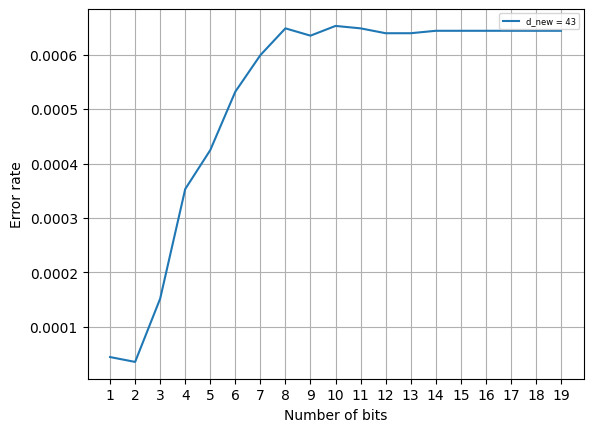

In [14]:
import matplotlib.pyplot as plt

for d_new, data in d_new_dict.items():
    if d_new != 43:
        continue

    errs = data["mean_err_per_bit"]/data["shots"]
    bits = data["nb_of_bits"]

    print(errs)

    plt.plot(bits, errs, label=f"d_new = {d_new}")
    plt.legend(fontsize=6)
    plt.grid()

plt.xlabel("Number of bits")
plt.xticks(nb_of_bits)
plt.ylabel("Error rate")
